In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

IMG_WIDTH, IMG_HEIGHT = 224, 224

import tensorflow_hub as hub
from tensorflow.keras.applications.densenet import (
    DenseNet121,
    preprocess_input,
)
import pandas as pd
import numpy as np
import os

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import (
    Dense,
    GlobalAveragePooling2D,
    Conv2D,
    Flatten,
    GlobalMaxPooling2D,
    Dropout,
)

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Nadam
from datetime import datetime
from packaging import version
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import (
    TensorBoard,
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
)
import efficientnet.tfkeras as enet


gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(
            len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs",
        )
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU found!")
    quit()


def append_extension(fn):
    return (fn + ".jpg").zfill(7)


def ordered_logit(class_number):
    # zero portability
    target = np.zeros(4, dtype=int)
    target[: class_number - 2] = 1
    return target


DATADIR = r"./adult"
CSV_PATH = r"./adult/CastControls_ALP.xlsx"
response = pd.read_excel(CSV_PATH, sheet_name=0,)[["GreenID", "Grade"]].dropna(
    axis=0, subset=["Grade"]
)
response.Grade = response.Grade.astype("int")
response.GreenID = response.GreenID.astype("str").apply(append_extension)
response = response[response.Grade != 99]
response = pd.concat(
    [response, pd.DataFrame.from_dict(dict(response.Grade.apply(ordered_logit))).T,],
    axis=1,
)


# shuffle dataset
response = response.sample(frac=1)
seed = np.random.randint(30027)


def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))


def soft_acc_multi_output(y_true, y_pred):
    return K.mean(
        K.all(
            K.equal(
                K.cast(K.round(y_true), "int32"), K.cast(K.round(y_pred), "int32"),
            ),
            axis=1,
        )
    )

from tensorflow.keras import mixed_precision

policy = tf.keras.mixed_precision.experimental.Policy("mixed_float16")
mixed_precision.experimental.set_policy(policy)

1 Physical GPUs, 1 Logical GPUs


In [2]:
def generate_train_val_test(train_index, val_index, test_index):
    train_dataset = response.iloc[train_index]
    val_dataset = response.iloc[val_index]
    test_dataset = response.iloc[test_index]
    train_gen = ImageDataGenerator(
        rotation_range=15,
        fill_mode="reflect",
        horizontal_flip=True,
        rescale=1.0 / 255.0,
        zoom_range=0.1,
    )
    valid_test_gen = ImageDataGenerator(rescale=1.0 / 255.0,)

    train_set = train_gen.flow_from_dataframe(
        dataframe=train_dataset,
        directory=DATADIR,
        x_col="GreenID",
        target_size=(380, 380),
        color_mode="rgb",
        subset="training",
        shuffle=True,
        y_col=[0, 1, 2, 3,],
        class_mode="raw",
    )

    validation_set = valid_test_gen.flow_from_dataframe(
        dataframe=val_dataset,
        directory=DATADIR,
        x_col="GreenID",
        target_size=(380, 380),
        color_mode="rgb",
        subset="training",
        shuffle=False,
        batch_size=64,
        y_col=[0, 1, 2, 3,],
        class_mode="raw",
    )

    test_set = valid_test_gen.flow_from_dataframe(
        dataframe=test_dataset,
        directory=DATADIR,
        x_col="GreenID",
        target_size=(380, 380),
        color_mode="rgb",
        subset="training",
        shuffle=False,
        batch_size=64,
        y_col=[0, 1, 2, 3,],
        class_mode="raw",
    )
    return train_set, validation_set, test_set


from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
innerkf = StratifiedKFold(n_splits=2, shuffle=True, random_state=seed)
response = response.sample(frac=1.0)
early_stopping = EarlyStopping(
    monitor="val_loss", patience=50, restore_best_weights=True,
)
reduce_lr_plateau = ReduceLROnPlateau(monitor="val_loss", patience=7, factor=0.8)

trainable_sequence = np.array([469, 464, 460, 452, 449, 447, 439, 436, 432, 424, 421, 417, 409, 406,
       402, 394, 391, 387, 379, 376, 372, 364, 361, 357, 349, 346, 342,
       334, 331, 329, 321, 318, 314, 306, 303, 299, 291, 288, 284, 276,
       273, 269, 261, 258, 254, 246, 243, 241, 233, 230, 226, 218, 215,
       211, 203, 200, 196, 188, 185, 181, 173, 170, 166, 158, 155, 153,
       145, 142, 138, 130, 127, 123, 115, 112, 108, 100,  97,  95,  87,
        84,  80,  72,  69,  65,  57,  54,  50,  42,  39,  37,  29,  26,
        22,  14,  12,   4,   1])


def generate_base_model():
    conv_base = enet.EfficientNetB4(
        include_top=False, input_shape=(380, 380, 3), pooling="avg", weights="noisy-student",
    )
    conv_base.trainable = False

    x = conv_base.output
    x = Dropout(0.85)(x)
    preds = Dense(4, activation="sigmoid")(x)
    model = Model(inputs=conv_base.input, outputs=preds)

    model.compile(
        optimizer=keras.optimizers.Nadam(),
        loss="binary_crossentropy",
        metrics=[soft_acc_multi_output],
    )

    return model


def fine_tune_model(model, fine_tune=None):
    if fine_tune is None:
        try:
            fine_tune = [layer.name for layer in model.layers].index(r"top_conv")
        except:
            pass

    model.trainable = True
    for layer in model.layers[:fine_tune]:
        layer.trainable = False
    for layer in model.layers[fine_tune:]:
        layer.trainable = True

    model.compile(
        optimizer=keras.optimizers.Nadam(),
        loss="binary_crossentropy",
        metrics=[soft_acc_multi_output],
    )

    return model

In [3]:
import gc
def stratified_cv(fine_tune_layer=None):
    acc_coef_scores = []
    raw_outputs = []
    for train_index, val_test_index in kf.split(
        np.zeros(len(response)), response["Grade"]
    ):
        val_index, test_index = next(
            innerkf.split(
                np.zeros(len(val_test_index)), response["Grade"].iloc[val_test_index]
            )
        )
        val_index, test_index = val_test_index[val_index], val_test_index[test_index]
        train_set, validation_set, test_set = generate_train_val_test(
            train_index, val_index, test_index
        )
        model = generate_base_model()

        _ = model.fit(
            x=train_set,
            epochs=10,
            validation_data=validation_set,
            callbacks=[early_stopping, reduce_lr_plateau],
            verbose=0,
        )

        model = fine_tune_model(model, fine_tune=fine_tune_layer)

        _ = model.fit(
            x=train_set,
            epochs=200,
            validation_data=validation_set,
            callbacks=[early_stopping, reduce_lr_plateau],
            verbose=0,
        )

        batch = next(test_set)
        true_labels = batch[1]
        predictions = model.predict(batch[0])
        acc = soft_acc_multi_output(predictions, true_labels).numpy()
        corr = np.corrcoef(np.sum(predictions, axis=1), np.sum(true_labels, axis=1))[0][
            1
        ]
        acc_coef_scores.append([acc, corr])
        raw_outputs.append([np.array(response.iloc[test_index].index), true_labels, predictions])
        del train_set, validation_set, test_set, _, model, batch, true_labels, predictions, acc, corr
        tf.keras.backend.clear_session()
        gc.collect()
    return acc_coef_scores, raw_outputs

In [ ]:
#  np.where(np.array(['conv' in layer.name for layer in model.layers]) == True)[0][::-1]
trainable_sequence = np.array([469, 464, 460, 452, 449, 447, 439, 436, 432, 424, 421, 417, 409, 406,
       402, 394, 391, 387, 379, 376, 372, 364, 361, 357, 349, 346, 342,
       334, 331, 329, 321, 318, 314, 306, 303, 299, 291, 288, 284, 276,
       273, 269, 261, 258, 254, 246, 243, 241, 233, 230, 226, 218, 215,
       211, 203, 200, 196, 188, 185, 181, 173, 170, 166, 158, 155, 153,
       145, 142, 138, 130, 127, 123, 115, 112, 108, 100,  97,  95,  87,
        84,  80,  72,  69,  65,  57,  54,  50,  42,  39,  37,  29,  26,
        22,  14,  12,   4,   1])

# any trainable sequence
# trainable_sequence = np.array([469, 465, 464, 461, 460, 458, 457, 453, 452, 450, 449, 448, 447,
#        445, 444, 440, 439, 437, 436, 433, 432, 430, 429, 425, 424, 422,
#        421, 418, 417, 415, 414, 410, 409, 407, 406, 403, 402, 400, 399,
#        395, 394, 392, 391, 388, 387, 385, 384, 380, 379, 377, 376, 373,
#        372, 370, 369, 365, 364, 362, 361, 358, 357, 355, 354, 350, 349,
#        347, 346, 343, 342, 340, 339, 335, 334, 332, 331, 330, 329, 327,
#        326, 322, 321, 319, 318, 315, 314, 312, 311, 307, 306, 304, 303,
#        300, 299, 297, 296, 292, 291, 289, 288, 285, 284, 282, 281, 277,
#        276, 274, 273, 270, 269, 267, 266, 262, 261, 259, 258, 255, 254,
#        252, 251, 247, 246, 244, 243, 242, 241, 239, 238, 234, 233, 231,
#        230, 227, 226, 224, 223, 219, 218, 216, 215, 212, 211, 209, 208,
#        204, 203, 201, 200, 197, 196, 194, 193, 189, 188, 186, 185, 182,
#        181, 179, 178, 174, 173, 171, 170, 167, 166, 164, 163, 159, 158,
#        156, 155, 154, 153, 151, 150, 146, 145, 143, 142, 139, 138, 136,
#        135, 131, 130, 128, 127, 124, 123, 121, 120, 116, 115, 113, 112,
#        109, 108, 106, 105, 101, 100,  98,  97,  96,  95,  93,  92,  88,
#         87,  85,  84,  81,  80,  78,  77,  73,  72,  70,  69,  66,  65,
#         63,  62,  58,  57,  55,  54,  51,  50,  48,  47,  43,  42,  40,
#         39,  38,  37,  35,  34,  30,  29,  27,  26,  23,  22,  20,  19,
#         15,  14,  13,  12,  10,   9,   5,   4,   2,   1])

from tqdm import tqdm

fine_tune_scores_acc_coef = []
fine_tune_raw_outputs = []

for i in tqdm(range(27,60)):
    fine_tune = trainable_sequence[i]
    acc_coef_scores, raw_outputs = stratified_cv(fine_tune)
    fine_tune_scores_acc_coef.append(acc_coef_scores)
    fine_tune_raw_outputs.append(raw_outputs)
    np.save(r"./stratified_cross_validation_results/effB4/multinomial_acc_coef_27-60", np.array(fine_tune_scores_acc_coef))
    np.save(r"./stratified_cross_validation_results/effB4/multinomial_raw_outputs_27-60", np.array(fine_tune_raw_outputs))
    del acc_coef_scores, raw_outputs
    tf.keras.backend.clear_session()
    gc.collect()


  0%|                                                                                                                         | 0/33 [00:00<?, ?it/s]C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:282: UserWarning: Found 5 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)
C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 450 validated image filenames.
Found 57 validated image filenames.
Found 56 validated image filenames.


C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:282: UserWarning: Found 5 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)
C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 450 validated image filenames.
Found 57 validated image filenames.
Found 56 validated image filenames.


C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:282: UserWarning: Found 5 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)
C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 450 validated image filenames.
Found 57 validated image filenames.
Found 56 validated image filenames.


C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:282: UserWarning: Found 5 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)
C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 450 validated image filenames.
Found 57 validated image filenames.
Found 56 validated image filenames.


C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:282: UserWarning: Found 4 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)
C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:282: UserWarning: Found 2 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 452 validated image filenames.
Found 56 validated image filenames.
Found 55 validated image filenames.


  3%|███▏                                                                                                      | 1/33 [1:24:15<44:56:17, 5055.54s/it]C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:282: UserWarning: Found 5 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)
C:\Users\ferocs\anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 450 validated image filenames.
Found 57 validated image filenames.
Found 56 validated image filenames.


57
[[31 11  3  0  0]
 [10 30 13  1  0]
 [ 7 13 48 10  1]
 [ 0  4 13 28  4]
 [ 0  0  9 19 28]]
+++++++++++++++++++++++++++++++++
+++++++++++++++++++++++++++++++++
[[0.68888889 0.24444444 0.06666667 0.         0.        ]
 [0.18518519 0.55555556 0.24074074 0.01851852 0.        ]
 [0.08860759 0.16455696 0.60759494 0.12658228 0.01265823]
 [0.         0.08163265 0.26530612 0.57142857 0.08163265]
 [0.         0.         0.16071429 0.33928571 0.5       ]]
+++++++++++++++++++++++++++++++++
+++++++++++++++++++++++++++++++++
Accuracy:  58.303886925795055
Raw Correlation:  0.8264815116719291
Rounded Correlation:  0.8057403065637734
+++++++++++++++++++++++++++++++++
+++++++++++++++++++++++++++++++++
max accuracy with tuning from 361 layers, or tune 108 layers
[68.88888888888889, 55.55555555555556, 60.75949367088608, 57.14285714285714, 50.0]


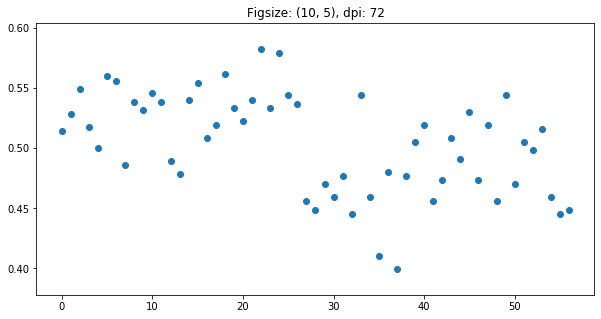

In [29]:
import IPython.display as display
import matplotlib.pyplot as plt

import numpy as np

# acc_coef8 = np.load(r"./stratified_cross_validation_results/effB4/multinomial_acc_coef_0-13.npy", allow_pickle=True)
raw_outputs8 = np.load(r"./stratified_cross_validation_results/effB4/multinomial_raw_outputs_0-13.npy", allow_pickle=True)
# acc_coef12 = np.load(r"./stratified_cross_validation_results/effB4/multinomial_acc_coef_6-30.npy", allow_pickle=True)
raw_outputs12 = np.load(r"./stratified_cross_validation_results/effB4/multinomial_raw_outputs_14-26.npy", allow_pickle=True)
raw_outputs27 = np.load(r"./stratified_cross_validation_results/effB4/multinomial_raw_outputs_27-59.npy", allow_pickle=True)
# acc_coef = np.vstack(np.array([acc_coef8,acc_coef12]))
raw_outputs = np.vstack(np.array([raw_outputs8,raw_outputs12, raw_outputs27]))
print(len(raw_outputs))


from sklearn.metrics import confusion_matrix


def show_confusion_matrix(raw_outputs, fine_tune_layers):

    y_true = np.sum(np.vstack(raw_outputs[fine_tune_layers, :, 1]), axis=1)
    y_pred = np.sum(
        np.rint(np.vstack(raw_outputs[fine_tune_layers, :, 2])), axis=1
    ).astype(int)
    return confusion_matrix(y_true, y_pred)

def show_matrix_percentage(confusion_matrix):
    return np.transpose(np.transpose(my_confusion_matrix) / np.sum(my_confusion_matrix, axis=1))

# total accuracy
def calculate_accuracy(my_confusion_matrix):
    return np.trace(my_confusion_matrix)/np.sum(my_confusion_matrix)

def raw_correlation(raw_outputs, fine_tune_layers):
    y_true = np.sum(np.vstack(raw_outputs[fine_tune_layers, :, 1]), axis=1).astype(float)
    y_pred = np.sum(np.vstack(raw_outputs[fine_tune_layers, :, 2]), axis=1).astype(float)
    return np.corrcoef(y_true, y_pred)

def rounded_correlation(raw_outputs, fine_tune_layers):
    y_true = np.sum(np.vstack(raw_outputs[fine_tune_layers, :, 1]), axis=1)
    y_pred = np.sum(np.rint(np.vstack(raw_outputs[fine_tune_layers, :, 2])), axis=1).astype(int)
    return np.corrcoef(y_true, y_pred)


max_acc_layer = np.argmax([calculate_accuracy(show_confusion_matrix(raw_outputs, i))  for i in range(len(raw_outputs))])

my_confusion_matrix = show_confusion_matrix(raw_outputs,max_acc_layer)
print(my_confusion_matrix)
print("+++++++++++++++++++++++++++++++++")
print("+++++++++++++++++++++++++++++++++")
print(show_matrix_percentage(my_confusion_matrix))
print("+++++++++++++++++++++++++++++++++")
print("+++++++++++++++++++++++++++++++++")
print("Accuracy: ",calculate_accuracy(my_confusion_matrix)*100)
print("Raw Correlation: ",raw_correlation(raw_outputs,max_acc_layer)[0][1])
print("Rounded Correlation: ",rounded_correlation(raw_outputs,max_acc_layer)[0][1])
import matplotlib.pyplot as plt

def plot(fs,dpi):
    fig, ax=plt.subplots(figsize=fs, dpi=dpi)
    ax.set_title("Figsize: {}, dpi: {}".format(fs,dpi))
    ax.scatter([i for i in range(len(raw_outputs))],[calculate_accuracy(show_confusion_matrix(raw_outputs, i))  for i in range(len(raw_outputs))])

plot((10,5),72)

print("+++++++++++++++++++++++++++++++++")
print("+++++++++++++++++++++++++++++++++")

trainable_sequence = np.array([469, 464, 460, 452, 449, 447, 439, 436, 432, 424, 421, 417, 409, 406,
       402, 394, 391, 387, 379, 376, 372, 364, 361, 357, 349, 346, 342,
       334, 331, 329, 321, 318, 314, 306, 303, 299, 291, 288, 284, 276,
       273, 269, 261, 258, 254, 246, 243, 241, 233, 230, 226, 218, 215,
       211, 203, 200, 196, 188, 185, 181, 173, 170, 166, 158, 155, 153,
       145, 142, 138, 130, 127, 123, 115, 112, 108, 100,  97,  95,  87,
        84,  80,  72,  69,  65,  57,  54,  50,  42,  39,  37,  29,  26,
        22,  14,  12,   4,   1])
print(f"max accuracy with tuning from {trainable_sequence[max_acc_layer]} layers, or tune {469-trainable_sequence[max_acc_layer]} layers")
print([show_matrix_percentage(my_confusion_matrix)[i,i]*100 for i in range(5)])

In [9]:
model = fine_tune_model(generate_base_model())
# model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 380, 380, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 190, 190, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 190, 190, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 190, 190, 48) 0           stem_bn[0][0]                    
______________________________________________________________________________________________

In [25]:
for i in enumerate([model.layers[layer].name for layer in trainable_sequence[:57]]):
    print(i)

(0, 'dense')
(1, 'top_conv')
(2, 'block7b_project_conv')
(3, 'block7b_dwconv')
(4, 'block7b_expand_conv')
(5, 'block7a_project_conv')
(6, 'block7a_dwconv')
(7, 'block7a_expand_conv')
(8, 'block6h_project_conv')
(9, 'block6h_dwconv')
(10, 'block6h_expand_conv')
(11, 'block6g_project_conv')
(12, 'block6g_dwconv')
(13, 'block6g_expand_conv')
(14, 'block6f_project_conv')
(15, 'block6f_dwconv')
(16, 'block6f_expand_conv')
(17, 'block6e_project_conv')
(18, 'block6e_dwconv')
(19, 'block6e_expand_conv')
(20, 'block6d_project_conv')
(21, 'block6d_dwconv')
(22, 'block6d_expand_conv')
(23, 'block6c_project_conv')
(24, 'block6c_dwconv')
(25, 'block6c_expand_conv')
(26, 'block6b_project_conv')
(27, 'block6b_dwconv')
(28, 'block6b_expand_conv')
(29, 'block6a_project_conv')
(30, 'block6a_dwconv')
(31, 'block6a_expand_conv')
(32, 'block5f_project_conv')
(33, 'block5f_dwconv')
(34, 'block5f_expand_conv')
(35, 'block5e_project_conv')
(36, 'block5e_dwconv')
(37, 'block5e_expand_conv')
(38, 'block5d_proje

In [5]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file="effnetB4.png", show_shapes=True, dpi=180)


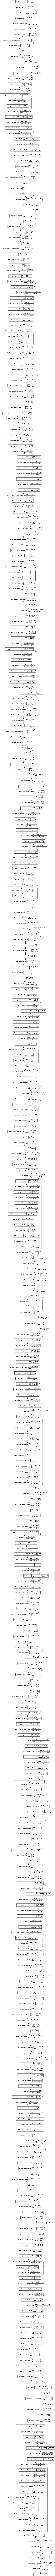

In [6]:
from IPython.display import Image
Image(filename="effnetB4.png")

In [ ]:
np.array(cvscores)[:, 1][:, 0][4].shape

In [ ]:
np.array(cvscores)[:, 0]

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(
    y_true=K.sum(K.cast(K.round(cvscores[1][1][0]), "int32"), axis=1).numpy(),
    y_pred=K.sum(K.cast(K.round(cvscores[1][1][1]), "int32"), axis=1).numpy(),
)

In [ ]:
mycsv = pd.DataFrame(
    np.hstack(
        np.array(
            [
                np.vstack(np.array(cvscores)[:, 1][:, 0]),
                np.vstack(np.array(cvscores)[:, 1][:, 1]),
            ]
        )
    )
)

In [ ]:
np.allclose(mycsv[range(4, 8)].to_numpy(), np.vstack(np.array(cvscores)[:, 1][:, 1]))

In [ ]:
mycsv.to_csv(
    "./stratified_cross_validation_results/effnet_multinomial.csv", index=False
)
# next time include which image?

In [ ]:
mycsv = pd.read_csv("./stratified_cross_validation_results/effnet_multinomial.csv")
y_true = np.sum((mycsv[[str(i) for i in range(0, 4)]]).to_numpy(dtype=int), axis=1)
y_pred = np.sum(
    np.rint((mycsv[[str(i) for i in range(4, 8)]]).to_numpy()), axis=1
).astype(int)

In [ ]:
from sklearn.metrics import confusion_matrix
my_confusion_matrix = confusion_matrix(y_true, y_pred,)
my_confusion_matrix

In [ ]:
np.transpose(np.transpose(my_confusion_matrix) / np.sum(my_confusion_matrix, axis=1))

In [ ]:
# coef
np.corrcoef(y_true, np.sum((mycsv[[str(i) for i in range(4, 8)]]).to_numpy(), axis=1))

In [ ]:
# acc
sum(np.isclose(y_true, y_pred)) / len(y_pred)

In [ ]:
# from tensorflow.keras.utils import plot_model

# plot_model(model, to_file="effnet.png", show_shapes=True)
# from IPython.display import Image

# Image(filename="effnet.png")

In [ ]:
response = response.sample(frac=1.0)

test_set = valid_gen.flow_from_dataframe(
    dataframe=response,
    directory=DATADIR,
    x_col="GreenID",
    target_size=(224, 224),
    color_mode="rgb",
    subset="validation",
    shuffle=False,
    batch_size=56,
    y_col=[0, 1, 2, 3,],
    class_mode="raw",
    #     seed = seed
)

batch = next(test_set)
true_labels = batch[1]
predictions = model.predict(batch[0])

print(model.metrics_names)
print(model.evaluate(test_set, verbose=0))  # loss/accuracy

In [ ]:
np.corrcoef(np.sum(predictions, axis=1), np.sum(true_labels, axis=1))

In [ ]:
fig, ax = plt.subplots(dpi=80)
batch = next(test_set)

y_true = batch[1]
y_pred = model.predict(batch[0])
print(soft_acc_multi_output(y_true, y_pred))

# print examples from the validation set
for i in range(len(batch[1])):
    img = batch[0][i]
    label = batch[1][i]
    assert (label == y_true[i]).all()
    right = K.all(
        K.equal(K.cast(K.round(label), "int32"), K.cast(K.round(y_pred[i]), "int32"),)
    )
    plt.imshow(img)
    plt.show()
    print(f"true label: {label}; rounded pred: {y_pred[i]}; Correct: {right}")

In [ ]:
list_ds = tf.data.Dataset.list_files(
    str("C:/Users/feroc/OneDrive - The University of Melbourne/Dataset/adult/*")
)


def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])


def get_label(file_path):
    # convert the path to a list of path components
    image_id = tf.strings.split(file_path, os.path.sep)[-1]
    return response.loc[] 

list(list_ds.take(1).as_numpy_iterator())[0]
tf.strings.split(list(list_ds.take(1).as_numpy_iterator())[0],os.path.sep)[-1].numpy()